# Quick Tour of BastionLab

## Why BastionLab?
Data owners often need or wish that remote data scientists would access their datasets - like a hospital might want to valorize their data to external parties, startups, labs, or receive help from external experts, for instance. 
The problem is that the most popular solution is to give access to a Jupyter Python notebook installed on the data owner infrastructure. 


![](https://github.com/mithril-security/bastionlab/raw/master/docs/assets/current_solution.png)

This is dangerous, because it exposes the dataset to serious data leakages. Jupyter was not made for this task and exfiltrating data can easily be done.
That is why we have built BastionLab, a data science framework to perform remote and secure Exploratory Data Analysis. Data scientists can remotely run queries on data frames without seeing the original data or intermediary results - according to the strict privacy policies defined by the data owner.


![](https://github.com/mithril-security/bastionlab/raw/master/docs/assets/proposed_solution.png)

BastionLab features include:
- Showing only aggregated results to maintain privacy with a minimal sample size to ensure the anonymization of each individual
- When case rows have to be displayed, only a minimal amount of information is shown, and all data shared is recorded and tracked. 

Differential Privacy will be integrated transparently in the future.

Technically, the framework uses polars (a Rust equivalent of pandas) lazy API to construct the queries locally. Once built, the queries are sent to the remote server of BastionLab and executed, if they pass the privacy policy rules defined by the data owner. BastionLab supports most data wrangling operations, like selects, groupbys, joins…

## Tutorial’s Introduction

In the following notebook tutorial, we will show you how to install BastionLab and use a few basic functionalities. We’ll use a mock example in which the data owner puts a Titanic passengers dataset at the disposal of the data scientist. 

“Titanic - Machine Learning from Disaster” dataset can be found on Kaggle and downloaded with a free user account https://www.kaggle.com/competitions/titanic/data.

Alternatively you can use the cell below:

In [ ]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

This notebook is divided into three parts:
- Installation of BastionLab Client and Server
- The Data Owner's Side
- The Data Scientist's Side


By the end, the data scientist will be able to do Exploratory Data Analysis remotely, under the constraints defined by the data owner.


### Technical Requirements

To start this tutorial, ensure the following are already installed in your system:
- Python3.7 or greater (get the latest version of Python at https://www.python.org/downloads/ or with your operating system’s package manager)
- [Python Pip](https://pypi.org/project/pip/) (PyPi), the package manager
- [Docker](https://www.docker.com/) 

*Here's the [Docker official tutorial](https://docker-curriculum.com/) to set it up on your computer.*


## Installing BastionLab Client

In [ ]:
!pip install bastionlab

## Installing BastionLab Server

### Using the official docker image

In [ ]:
!docker pull mithrilsecuritysas/bastionlab:latest

*To install Bastion Client or Server locally, refer to our more detailed [Installation Tutorial](docs/).*

## Setting up the keys

BastionLab only accept request from authenticated users. Authentication is done with asymmetric cryptography: the data owners provides a list of authorized public keys to the server upon start up and all users must provide their corresponding private key to the client when they connect to the server. The client then transparently creates a session for the user.

BastionLab provides a utility module to manage the keys. We will use it to create the public and private keys for a single user.

Firts create two directories to store the keys:

In [ ]:
!mkdir pubkeys
!mkdir privkeys

Then create the public and private keys using the BastionLab library. This may be done in the interpreter:

In [1]:
from bastionlab import SigningKey

# We create the Data Owner's private and public keys.
data_owner_signing_key = SigningKey.from_pem_or_generate("privkeys/data_owner.key.pem")
data_owner_public_key = data_owner_signing_key.pubkey.save_pem("pubkeys/data_owner.pem")

"""
    In order to authentify the data scientist(s), the data onwer would have to start 
    an instance of the BastionLab server with all the **allow** public keys. In the case of 
    this tutorial, the data owner's public key and the public key of the data scientist(s)

    And for the purpose of this tutorial, the data scientist public and private keys are created right below.
"""

data_scientist_signing_key = SigningKey.from_pem_or_generate(
    "privkeys/data_scientist.key.pem"
)
data_scientist_public_key = data_scientist_signing_key.pubkey.save_pem(
    "pubkeys/data_scientist.pem"
)

Now, we start the instance of the BastionLab server by running the following docker command while binding the `pubkeys` directory created above to the server. 

## Running BastionLab Server

### Using the official Docker image

In [ ]:
!docker run -it -p 50056:50056 --env DISABLE_AUTHENTICATION=1 --mount type=bind,source=$(pwd)/pubkeys,target=/app/bin/keys mithrilsecuritysas/bastionlab:latest

# Data Owner's Side
In this part of the notebook, the data owner can setup the BastionLab server in his infrastructure and share a dataset with a privacy policy in place.
It is divided into two steps: 
- Uploading the dataset to BastionLab 
- Choose a privacy policy regarding data exposure to the data scientist


### Upload the data frame to the BastionLab Client
Once downloaded, you can use polars to load it as a DataFrame:


In [2]:
import polars as pl

df = pl.read_csv("titanic.csv")

To upload the DataFrame to BastionLab, first open a connection to the server by providing its hostname. 


In [3]:
from bastionlab import Connection

connection = Connection("localhost", 50056, signing_key=data_owner_signing_key)

Using BastionLab client, you may now upload your data to the server in a secure and private fashion.

In [4]:
connection.client.send_df(df, blacklist=["Name"])

FetchableLazyFrame(identifier=a7ebb3c9-ee58-4078-a927-550f8b32123e)

### Privacy Policy Options
BastionLab offers many options to finetune your Privacy Policy.<br>

A policy is a set of policy entries, one per type of privileged action. Currently, BastionLab only have one privileged action which is fetching a DataFrame.

Each entry consists of two rules:
- an `accept` rule that details the conditions a request must meet to be automatically accepted,
- an `approval` rule that details the conditions a request must meet to be presented to the data owner.
When a request is presented to the data owner, they can either accept or reject it.

If a request does not meet any of the rules, it is droped by the server.

In the example above, we do not supply a policy, telling the client to use the default one. This policy accepts all request that aggregate at least 10 rows of the original data sent by the data owner and ask approval for all others (i.e. no requests are rejected rightaway).

Here is the default policy's definition:

```py
DEFAULT_POLICY = Policy(fetch=PolicyEntry(accept=Aggregation(min_agg_size=10), approval=TrueRule()))
```

Change the `min_agg_size` parameter passed to the Aggregation rule to set the minimum number of rows per group in aggregation. If a query does not have at least the given minimum number of rows per group, it is *not* considered an aggregation, and the request is denied. This prevents queries that would specifically isolate an individual, which would in turn ease their identification (a process known as deanonymization in data privacy).<br>

BastionLab also allows you to protect a list of sensitive columns with the `blacklist` parameter. Blacklisted columns cannot be displayed and will be filled with null values upon fetching.


### Reference Code

In [5]:
import polars as pl
from bastionlab import Connection

df = pl.read_csv("titanic.csv")

with Connection("localhost", 50056, signing_key=data_owner_signing_key) as client:
    client.send_df(
        df,
        blacklist=["Name"],
    )

## Data Scientist’s Side
In this part, we’ll show how the data scientist can access the Data Owner’s dataset, run queries, fetch the results, and display them.

This tutorial is divided into five steps:
- Access the data owner’s dataset
- Run queries
- Fetching the results
- Data visualization functions

### Access the Data Owner’s Dataset 

You'll encounter two core objects to access the dataset’s DataFrame in BastionLab: the RemoteLazyFrame and the FetchableLazyFrame.

First, you’ll need a RemoteLazyFrame, which is a reference to the DataFrame uploaded by the data owner, along with some metadata such as the names and types of the columns. 

This reference allows you to remotely run queries on the DataFrame without the need to download it and without the ability to see the initial data or intermediary results. 

As we do not know the unique identifier of the DataFrame uploaded by the data owner, we start by asking the server to list all available DataFrames.



In [6]:
import bastionlab

connection = Connection("localhost", 50056, signing_key=data_scientist_signing_key)

client = connection.client

all_rdfs = client.list_dfs()

rdf = all_rdfs[0]

The server returns a list of FetchableLazyFrames, a specific kind of RemoteLazyFrames, that we can inspect. In our case, we can just take the first one as the data owner has only uploaded one DataFrame so far.

### Running Queries

Now that you have a RemoteLazyFrame corresponding to the data owner’s DataFrame, it is time to run some queries on it.

To define these queries, you can directly use all the methods provided by polars’ lazy API. Here, the adjective lazy means that no computation will be run unless explicitly needed. This allows the data scientist to build queries with a Pythonic approach from the RemoteLazyFrame, and when an operation needs to be executed on the data, the query is serialized and sent to the server. 

This is done with the **collect() method** to trigger the execution of all the recorded operations on the server.


In [7]:
rdf1 = rdf.head(5)
print(rdf1)

rdf2 = rdf1.collect()
print(rdf2)

RemoteLazyFrame
FetchableLazyFrame(identifier=a2a55486-3de4-4758-95db-3d4ccd40842f)


In this example, the first line returns a new RemoteLazyFrame that records the head operation - nothing happens on the server. In the second line, however, the call to collect()  sends a query to the server instructing it to do a head operation, and will run it right away.


What is key to understanding, is that **every call to collect() will create a new DataFame on the server side that contains the result**.

**On the client side, collect() returns a new FetchableLazyFrame that references the result on the server.**

### Fetching Results

At some point in your process, you will need to download the results to use them locally or to display them. This can be achieved with the fetch method.

The fetch method is defined on the FetchableLazyFrame class which extends the RemoteLazyFrame class. 

Recall that we’ve already seen the two ways of getting FetchableLazyFrames: by listing available DataFrames on the server, and by calling collect() on any RemoteLazyFrame. 
In practice, this means that fetch() may only be called on references to DataFrames already available on the server or after a call to collect(). As no computation has run before you call collect(), it wouldn’t actually make sense to fetch() the result because it does not yet exist! 


In [8]:
rdf.head(5).collect().fetch()

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,null,"""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,null,"""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,null,"""female""",26.0,0,0,"""STON/O2. 31012...",7.925,null,"""S"""
4,1,1,null,"""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,null,"""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In addition, fetch() downloads the result DataFrame after performing some checks on how it was obtained and what the data owner authorizes you to do in their policy. These checks allow BastionLab to uphold a decent level of privacy without too big an impact on your workflow. If you need more guarantees, we plan to support differential privacy in the future as an optional feature.

In our case, the data owner has set up a policy which allows downloading aggregated DataFrames right away but requires approval for all others. This means that, for example, we cannot directly print out rows from the original DataFrame because it wouldn’t count as an aggregation. Instead, the server requires the data owner’s approval first. This explains the message printed in the terminal when we try to fetch() the result of the head operation. 

Here, the data owner has accepted to disclose the data, which will allow us to download and to display it. However, note that the Name column have been filled with Null values as it has been blacklisted.


Let’s now try a more involved query: we compute the survival rates of the passengers on the Titanic based on their ticket class.

In [9]:
per_class_rates = (
    rdf.select([pl.col("Pclass"), pl.col("Survived")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
    .fetch()
)
per_class_rates

Pclass,Survived
i64,f64
1,0.62963
2,0.472826
3,0.242363


Once again, we must use:
- collect() to run the computation on the server
- fetch() to retrieve the result locally 

In this case, no message appears because the query involves an aggregation step.

### Data Visualization Functions

The data scientist can also use plotting functions to visualize data while still upholding data privacy. One example feature is that the data is aggregated by default and although the size of bins is modifiable when calling the functions, BastionLab will check that this value enables sufficient data anonymity.

#### Barplot

You can generate a barplot visualization of the data showing the number of survivors per age category.


Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


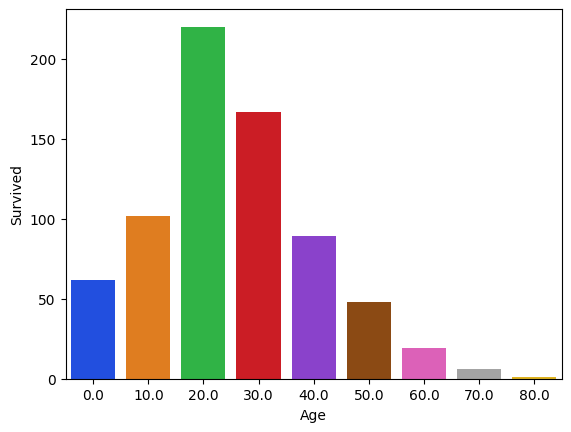

In [10]:
rdf.histplot(col_x="Age", col_y="Survived", bins=10, palette="bright")

You can generate a scatterplot visualization of this relationship.


Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


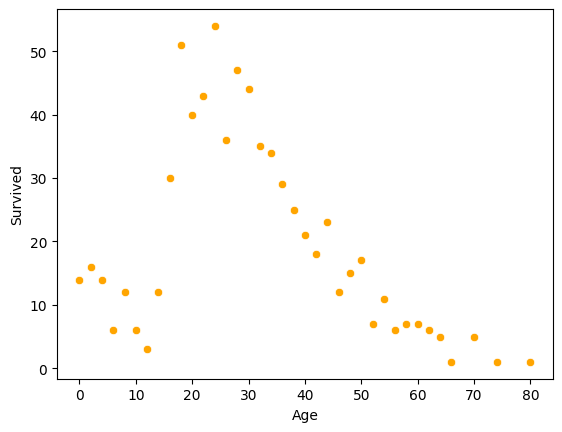

In [11]:
rdf.scatterplot(col_x="Age", col_y="Survived", bins=2, color="orange")

#### Curveplot

You can generate a curveplot to create a regression best-fit curve visualization of this relationship.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


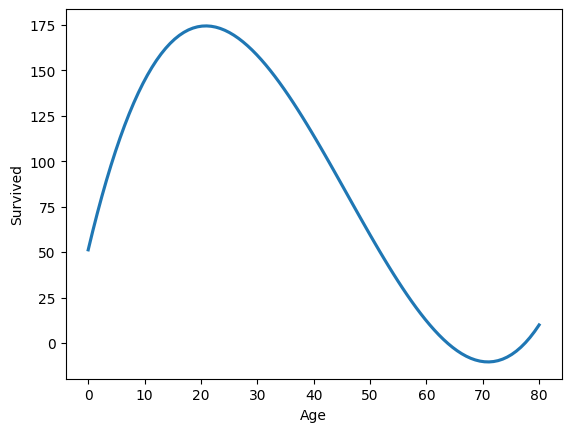

In [12]:
rdf.curveplot(col_x="Age", col_y="Survived", bins=10)

For more information on these functions, check out our data visualization tutorial [here](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/visualization/).